Peak |Δg| : 125.75 mGal
Peak |N|  : 3.412  m


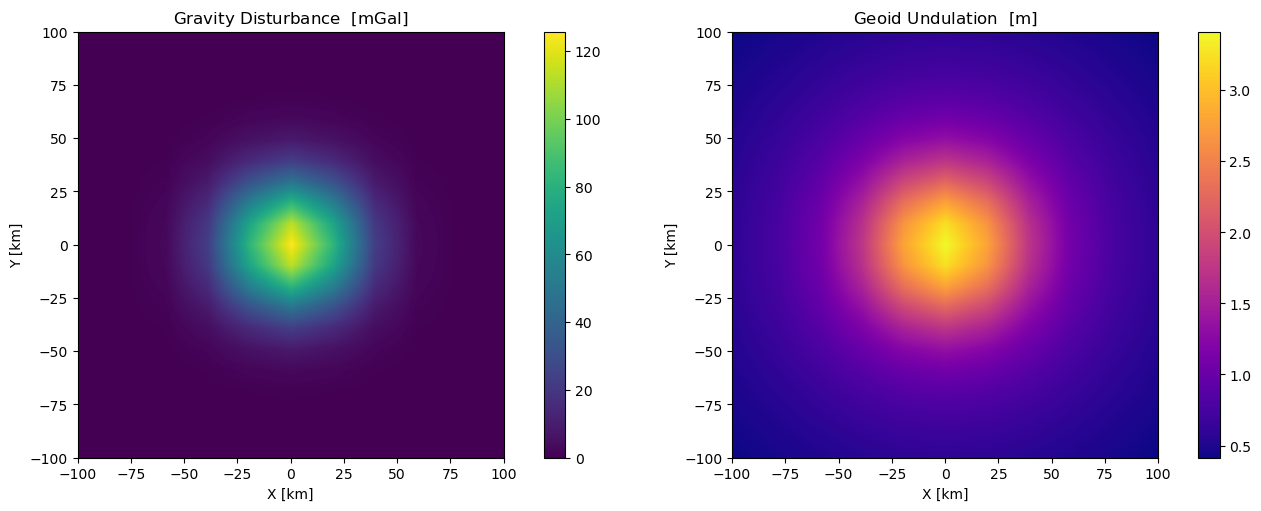

In [5]:
# ============================================================
#  SINGLE-GAUSSIAN SYNTHETIC TEST
# ============================================================

import numpy as np
import pyshtools as pysh
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# -------------------- 1. physical parameters --------------------
R      = 6_371e3          # Earth radius [m]
g0     = 9.80665          # mean gravity [m/s^2]
t      = 10e3             # vertical thickness of the body [m]
d_rho  = 300              # density contrast [kg/m^3]
FWHM   = 50e3             # lateral full width at half-maximum [m]
sigma  = FWHM / 2.355

# -------------------- 2. density on the surface -----------------
rho_surf = d_rho * np.exp(-(x_g**2 + y_g**2) / (2.0 * sigma**2))

# -------------------- 3. spherical-harmonic expansion -----------
rho_grid = pysh.SHGrid.from_array(rho_surf)
Clm_rho  = rho_grid.expand(normalization='schmidt',
                           csphase=1,
                           lmax_calc=lmax)

ℓ        = np.arange(lmax + 1)
G_const  = pysh.constants.G.value

# ---------- 4. scale for a finite-thickness volumetric layer ----
scale_V  = 4.0 * np.pi * G_const * R * t / (2*ℓ + 1)

Clm_V    = Clm_rho.copy()
Clm_V.coeffs *= scale_V[np.newaxis, :, np.newaxis]

# ---------- 5. gravity coefficients & synthesis -----------------
scale_g  = -(ℓ + 1) / R
Clm_g    = Clm_V.copy()
Clm_g.coeffs *= scale_g[np.newaxis, :, np.newaxis]

g_DH = Clm_g.expand(grid='DH', lmax=lmax)        # [m/s²]
N_DH = Clm_V.expand(grid='DH', lmax=lmax) / g0   # [m]

print(f"Peak |Δg| : {np.max(np.abs(g_DH.data))*1e5:5.2f} mGal")
print(f"Peak |N|  : {np.max(np.abs(N_DH.data)):5.3f}  m")

# ------------------------------------------------------------
# 6.  LOCAL CARTESIAN WINDOW
# ------------------------------------------------------------
lat0_deg = 0.0            # centre-latitude of local map
lon0_deg = 0.0            # centre-longitude of local map

n_xy = 401
x = np.linspace(-region,  region, n_xy)           # [m]
y = np.linspace(-region,  region, n_xy)           # [m]
X, Y = np.meshgrid(x, y)

# inverse projection to (lat, lon)
lat_xy = (Y / R) * (180.0 / np.pi) + lat0_deg
lon_xy = (X / (R * np.cos(np.radians(lat0_deg)))) * (180.0 / np.pi) + lon0_deg

# ------------------------------------------------------------
# 7.  INTERPOLATION  (DH to Cartesian)
# ------------------------------------------------------------
interp_g = RegularGridInterpolator((lat, lon), g_DH.data   * 1e5,  # mGal
                                   bounds_error=False, fill_value=np.nan)
interp_N = RegularGridInterpolator((lat, lon), N_DH.data,           # m
                                   bounds_error=False, fill_value=np.nan)

pts      = np.column_stack((lat_xy.ravel(), lon_xy.ravel()))
g_xy     = interp_g(pts).reshape(n_xy, n_xy)
N_xy     = interp_N(pts).reshape(n_xy, n_xy)

# ------------------------------------------------------------
# 8.  PLOT
# ------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

im0 = axs[0].imshow(-g_xy, origin='lower',
                    extent=[-region/1e3, region/1e3, -region/1e3, region/1e3],
                    cmap='viridis', interpolation='bicubic')
axs[0].set(title=r"Gravity Disturbance  [$\mathrm{mGal}$]",
           xlabel="X [km]", ylabel="Y [km]")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(N_xy, origin='lower',
                    extent=[-region/1e3, region/1e3, -region/1e3, region/1e3],
                    cmap='plasma', interpolation='bicubic')
axs[1].set(title=r"Geoid Undulation  [$\mathrm{m}$]",
           xlabel="X [km]", ylabel="Y [km]")
fig.colorbar(im1, ax=axs[1])

plt.show()

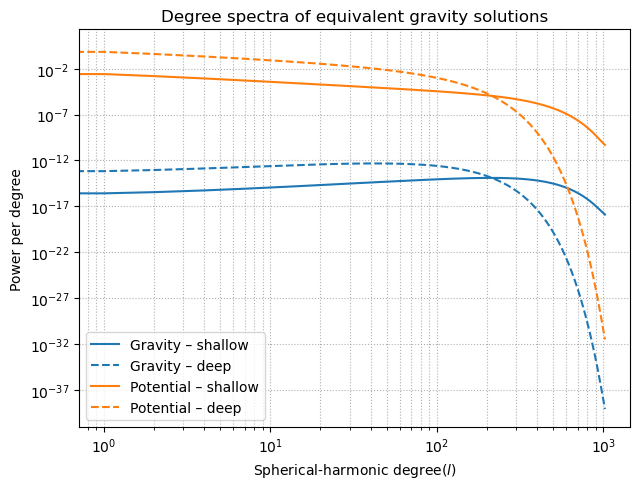

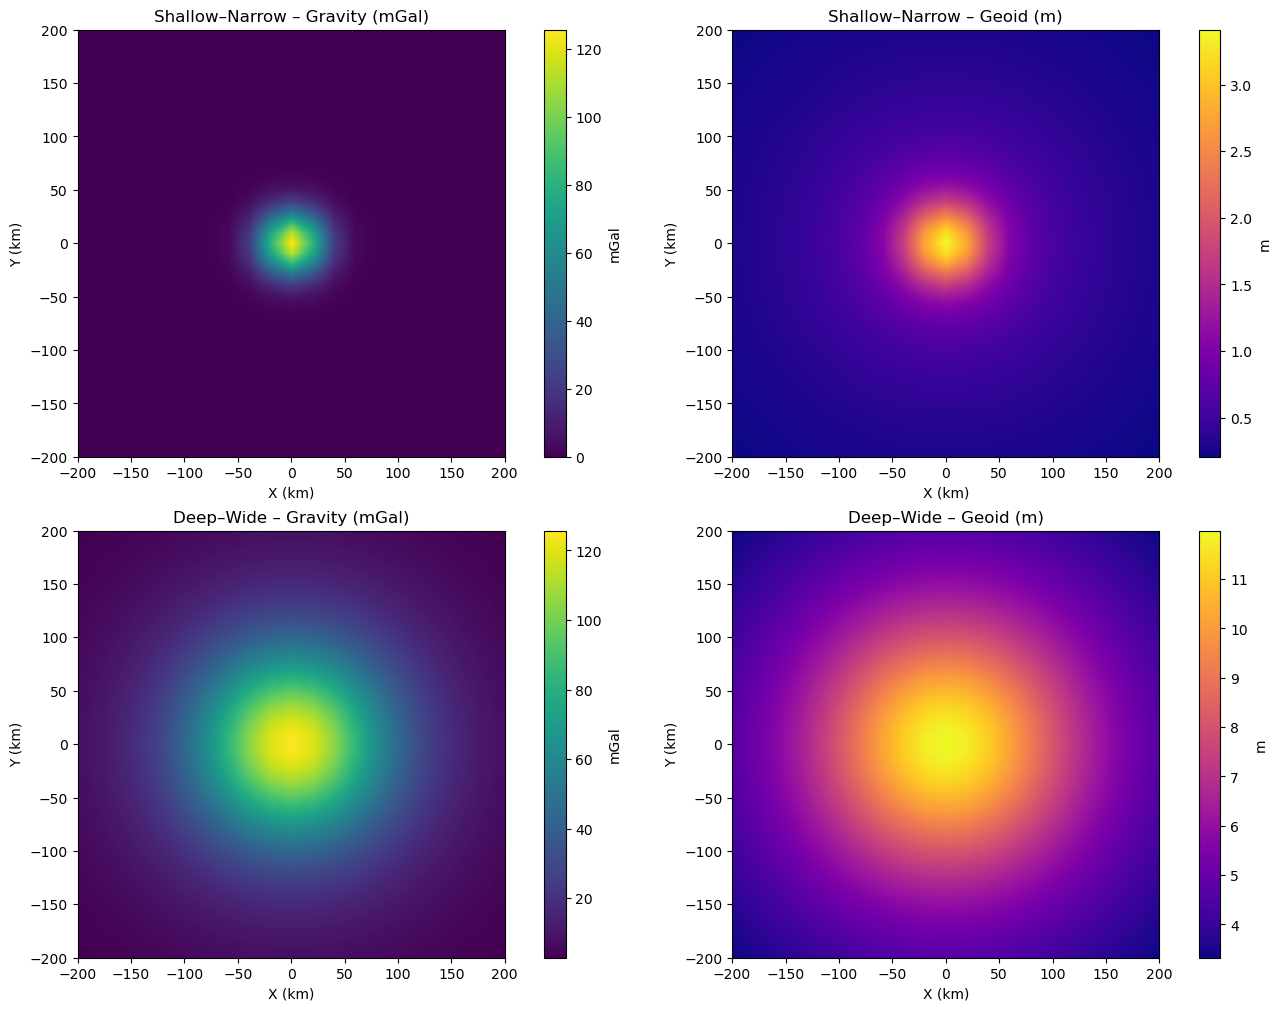

Shallow–Narrow:  |Δg|_max = 125.7531 mGal, |N|_max = 3.4119 m
Deep–Wide:  |Δg|_max = 125.7531 mGal, |N|_max = 11.9858 m


In [12]:
# ==============================================================
#  Two volumetric Gaussian anomalies (non-uniqueness demo)
# ==============================================================
import numpy as np
import pyshtools as pysh
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from pyshtools import spectralanalysis as sa

# ---------- constants and grids --------------------------------
R      = 6_371e3               
g0     = 9.80665                
G      = pysh.constants.G.value
lmax   = 1023
nlat   = nlon = 2049             # DH grid
lat    = np.linspace(-90,  90,  nlat)
lon    = np.linspace(-180, 180, nlon)
lon_g, lat_g = np.meshgrid(lon, lat)
xg = R*np.radians(lon_g)*np.cos(np.radians(lat_g))
yg = R*np.radians(lat_g)

# ---------- Gaussian parametrisation ---------------------------
t          = 10e3                # slab thickness [m]
rho_peak   = 300.0               # starting density contrast [kg/m^3]
FWHM_s     = 50e3                # shallow half-width  [m]
FWHM_d     = 100e3               # deep   half-width   [m]
sigma_s    = FWHM_s/2.355
sigma_d    = FWHM_d/2.355
depth_s    = 0.0                 # centre depth of shallow anomaly  [m]
depth_d    = 60e3                # centre depth of deep anomaly     [m]

# ---------- helper -------------------------------------------------
l_arr = np.arange(lmax+1)

def forward_gauss(sigma, depth, rho0):
    """Return gravity (mGal) and geoid (m) on a 400×400 km window."""
    r_c = R - depth
    # lateral Gaussian; mass per area = ρ t
    surf_mass = (rho0 * t) * np.exp(-(xg**2 + yg**2)/(2*sigma**2))

    # SH expansion of σ(θ,φ)
    Slm = pysh.SHGrid.from_array(surf_mass).expand(
              normalization='schmidt', csphase=1, lmax_calc=lmax)

    # potential at surface, scaled for shell radius r_c
    scale_V = (4.0*np.pi*G*r_c/(2*l_arr+1)) * (r_c/R)**(l_arr+1)
    Vlm     = Slm.copy();   Vlm.coeffs *= scale_V[np.newaxis,:,np.newaxis]

    # radial gravity, positive downward
    scale_g = (l_arr+1)/R
    glm     = Vlm.copy();   glm.coeffs *= scale_g[np.newaxis,:,np.newaxis]

    gDH  = glm.expand(grid='DH', lmax=lmax) * 1e5            # mGal
    NDH  = Vlm.expand(grid='DH', lmax=lmax) / g0             # m

    # project to 400×400 km Cartesian window
    region = 200e3
    nxy    = 401
    x = np.linspace(-region,  region, nxy)
    y = np.linspace(-region,  region, nxy)
    X, Y = np.meshgrid(x, y)
    lat_xy =  Y/R * 180/np.pi
    lon_xy = (X/(R*np.cos(0.0))) * 180/np.pi
    pts    = np.column_stack((lat_xy.ravel(), lon_xy.ravel()))
    g_loc  = RegularGridInterpolator((lat, lon), gDH.data,
                                     bounds_error=False)(pts).reshape(nxy,nxy)
    N_loc  = RegularGridInterpolator((lat, lon), NDH.data,
                                     bounds_error=False)(pts).reshape(nxy,nxy)
    return g_loc, N_loc

def forward_gauss_with_coeffs(sigma, depth, rho0):
    """Return g(x,y), N(x,y) as before, plus (glm, Vlm) coefficients."""
    r_c = R - depth
    surf_mass = (rho0 * t) * np.exp(-(xg**2 + yg**2)/(2*sigma**2))

    Slm = pysh.SHGrid.from_array(surf_mass).expand(
              normalization='schmidt', csphase=1, lmax_calc=lmax)

    scale_V = (4*np.pi*G*r_c/(2*l_arr+1)) * (r_c/R)**(l_arr+1)
    Vlm = Slm.copy();   Vlm.coeffs *= scale_V[np.newaxis,:,np.newaxis]
    scale_g = (l_arr+1)/R
    glm = Vlm.copy();   glm.coeffs *= scale_g[np.newaxis,:,np.newaxis]

    # (x,y) maps as in the original function ..............................
    region, nxy = 200e3, 401
    x = np.linspace(-region, region, nxy)
    y = np.linspace(-region, region, nxy)
    X, Y = np.meshgrid(x, y)
    lat_xy = Y/R * 180/np.pi
    lon_xy = (X/(R*np.cos(0.0))) * 180/np.pi
    pts = np.column_stack((lat_xy.ravel(), lon_xy.ravel()))
    g_loc = RegularGridInterpolator((lat, lon),
                                    glm.expand(grid='DH', lmax=lmax).data*1e5,
                                    bounds_error=False)(pts).reshape(nxy,nxy)
    N_loc = RegularGridInterpolator((lat, lon),
                                    Vlm.expand(grid='DH', lmax=lmax).data/g0,
                                    bounds_error=False)(pts).reshape(nxy,nxy)
    return g_loc, N_loc, glm, Vlm


# ---------- recompute with coefficient output ------------------------------
g_sh, N_sh, glm_sh, Vlm_sh = forward_gauss_with_coeffs(sigma_s, depth_s, rho_peak)

rho_d = rho_peak
for _ in range(20):
    g_de, N_de, glm_de, Vlm_de = forward_gauss_with_coeffs(sigma_d, depth_d, rho_d)
    if abs(1 - g_target/np.nanmax(np.abs(g_de))) < 1e-4:
        break
    rho_d *= g_target/np.nanmax(np.abs(g_de))

# ---------- spectral power (per degree) ------------------------------------
deg_power_g_sh = glm_sh.spectrum(unit='per_l')
deg_power_g_de = glm_de.spectrum(unit='per_l')
deg_power_V_sh = Vlm_sh.spectrum(unit='per_l')
deg_power_V_de = Vlm_de.spectrum(unit='per_l')
lvals = np.arange(deg_power_g_sh.size)

# ---------- plot spectra ---------------------------------------------------
plt.figure(figsize=(6.5,5))
plt.loglog(lvals, deg_power_g_sh, 'C0-',  label='Gravity – shallow')
plt.loglog(lvals, deg_power_g_de, 'C0--', label='Gravity – deep')
plt.loglog(lvals, deg_power_V_sh, 'C1-',  label='Potential – shallow')
plt.loglog(lvals, deg_power_V_de, 'C1--', label='Potential – deep')
plt.xlabel('Spherical-harmonic degree$(l)$')
plt.ylabel('Power per degree')
plt.legend()
plt.title('Degree spectra of equivalent gravity solutions')
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

# ---------- shallow reference model -----------------------------
g_sh, N_sh = forward_gauss(sigma_s, depth_s, rho_peak)
g_target   = np.nanmax(np.abs(g_sh))

# ---------- deep model: iterate density until |delta_g|max matches ----
rho_d = rho_peak
for _ in range(20):
    g_de, N_de = forward_gauss(sigma_d, depth_d, rho_d)
    ratio      = g_target / np.nanmax(np.abs(g_de))
    if abs(1-ratio) < 1e-4:         # convergence
        break
    rho_d *= ratio                  # scale density

# ---------- collect results --------------------------------------
models = {"Shallow–Narrow": (g_sh, N_sh),
          "Deep–Wide"     : (g_de, N_de)}

# ---------- plotting ---------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(13, 10), constrained_layout=True)

for i,(name,(g_loc,N_loc)) in enumerate(models.items()):
    im = axs[i,0].imshow(g_loc, origin='lower', cmap='viridis',
                         extent=[-200,200,-200,200])
    axs[i,0].set(title=f"{name} – Gravity (mGal)", xlabel='X (km)', ylabel='Y (km)')
    fig.colorbar(im, ax=axs[i,0]).set_label('mGal')

    im = axs[i,1].imshow(N_loc, origin='lower', cmap='plasma',
                         extent=[-200,200,-200,200])
    axs[i,1].set(title=f"{name} – Geoid (m)", xlabel='X (km)', ylabel='Y (km)')
    fig.colorbar(im, ax=axs[i,1]).set_label('m')

plt.show()

# ---------- numerical summary ------------------------------------
for name,(g_loc,N_loc) in models.items():
    print(f"{name}:  |Δg|_max = {np.nanmax(np.abs(g_loc)):.4f} mGal, "
          f"|N|_max = {np.nanmax(np.abs(N_loc)):.4f} m")


Stopping search: Swarm best objective change less than 1e-08
Taper centres  lc_s=175.7 , lc_d=67.3  (σL=150.0)


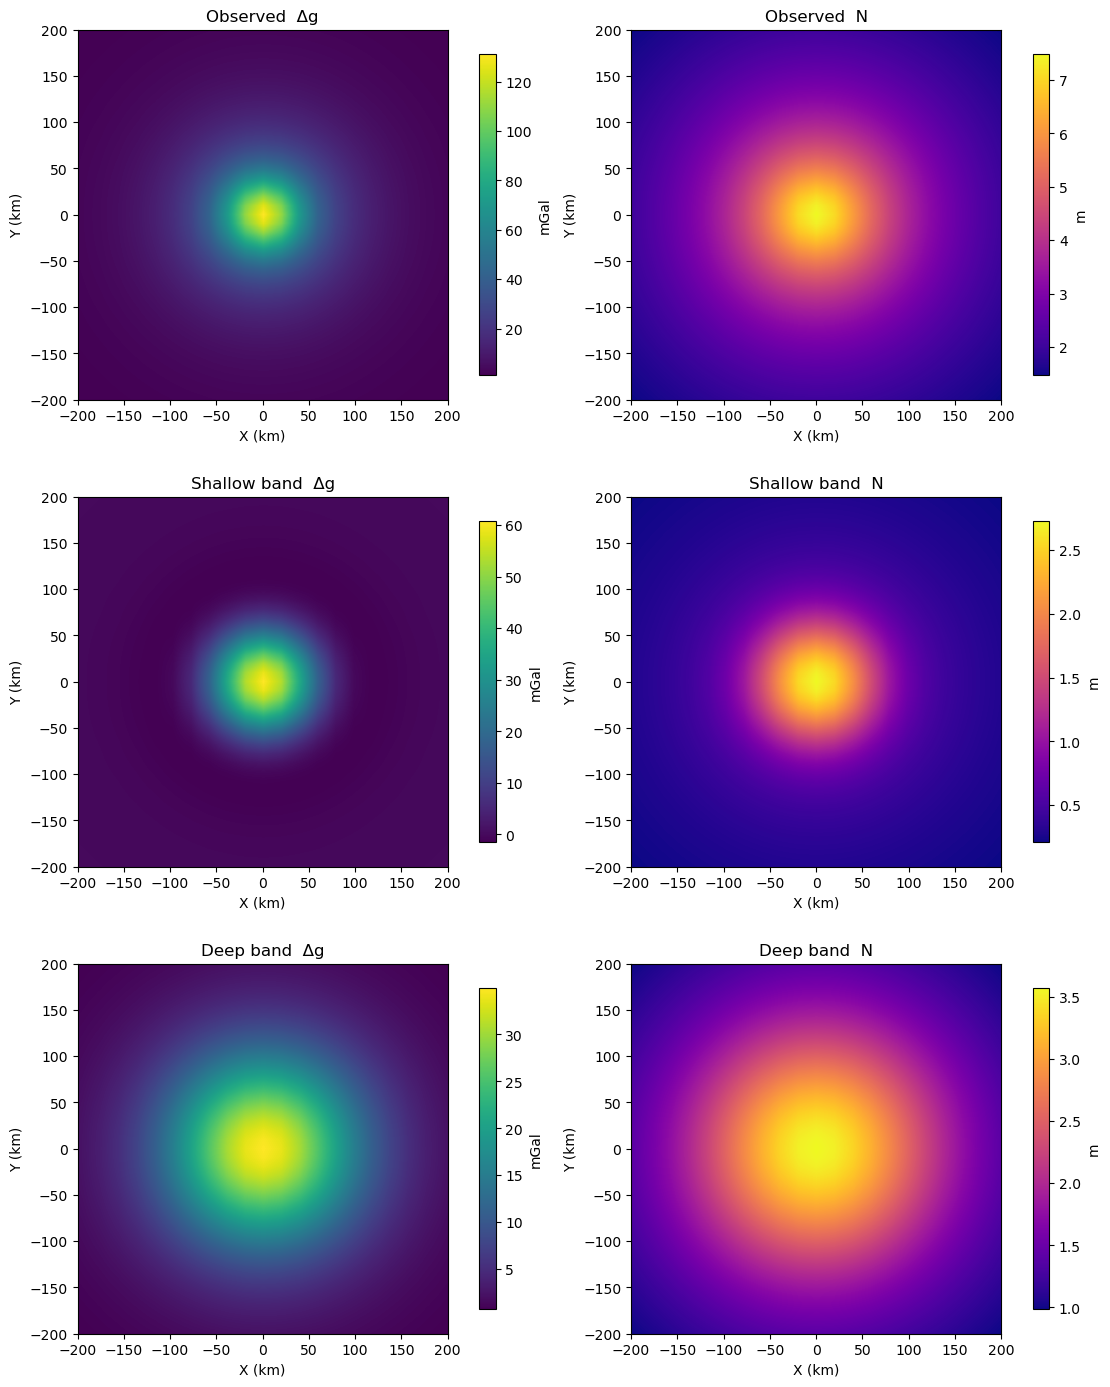

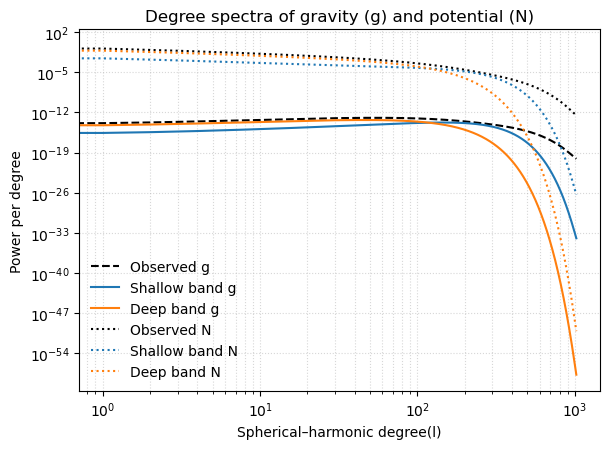

Obs: peak |Δg| = 131.22 mGal
Sh: peak |Δg| =  60.79 mGal
Dp: peak |Δg| =  34.97 mGal
Obs: peak |N|  =  7.489  m
Sh: peak |N|  =  2.730  m
Dp: peak |N|  =  3.575  m


In [93]:

# ==============================================================
#  Two Gaussian volumetric layers
#  PSO chooses band-pass centres for shallow / deep tapers
# ==============================================================

import numpy as np, matplotlib.pyplot as plt, pyshtools as pysh
import pyshtools.spectralanalysis as sa
from scipy.interpolate import RegularGridInterpolator
from pyswarm import pso

# ────────────────── constants & spherical grid ──────────────────
R, g0 = 6_371e3, 9.81
G     = pysh.constants.G.value
t     = 2e3                   # layer thickness (m)
lmax  = 1023
nlat  = nlon = 2*(lmax+1)     # DH grid

lat = np.linspace(-90,  90, nlat, endpoint=False)
lon = np.linspace(-180, 180, nlon, endpoint=False)
lon_g, lat_g = np.meshgrid(lon, lat)

xg = R*np.radians(lon_g)*np.cos(np.radians(lat_g))
yg = R*np.radians(lat_g)
ℓ  = np.arange(lmax+1)

# ────────────────── thin-layer forward model ────────────────────
def layer_gauss(σxy, depth, rho):
    """
    Gaussian surface-mass sheet on shell r_c = R - depth.
    Returns  (Δg_DH [mGal], N_DH [m], SHCoeffs glm)
    """
    σsurf = rho*t*np.exp(-(xg**2+yg**2)/(2*σxy**2))           # kg m⁻²
    Slm   = pysh.SHGrid.from_array(σsurf).expand('schmidt', csphase=1,
                                                lmax_calc=lmax)

    rc      = R - depth
    scale_V = (4*np.pi*G*rc/(2*ℓ+1)) * (rc/R)**(ℓ+1)
    Vlm     = Slm.copy(); Vlm.coeffs *= scale_V[None,:,None]
    glm     = Vlm.copy(); glm.coeffs *= ((ℓ+1)/R)[None,:,None]

    g = glm.expand(grid='DH', lmax=lmax).data[:nlat,:nlon]*1e5      # mGal
    N = Vlm.expand(grid='DH', lmax=lmax).data[:nlat,:nlon] / g0     # m
    return g, N, glm

# ------------------ true shallow & deep Gaussians ------------------
σ_s, dep_s, ρ_s = 50e3/2.355 , 20e3, 3000.   # shallow (σ=50 km / 2.355)
σ_d, dep_d, ρ_d = 100e3/2.355, 60e3, 2000.  # deep    (σ doubled)

gS,  NS,  glmS  = layer_gauss(σ_s, dep_s, ρ_s)
gD,  ND,  glmD  = layer_gauss(σ_d, dep_d, ρ_d)
gOBS, NOBS      = gS + gD,  NS + ND
glmOBS          = glmS + glmD

# ────────────────── band-pass optimisation ───────────────────────
def taper(lc, sig):
    """Gaussian in degree space"""
    return np.exp(-0.5*((ℓ-lc)/sig)**2)

def misfit(par):
    lc_s, lc_d, sig = par
    W_s, W_d = taper(lc_s, sig), taper(lc_d, sig)
    g_fit = (layer_from_coeffs(glmS, W_s) +
             layer_from_coeffs(glmD, W_d))
    return np.linalg.norm(gOBS - g_fit)

def layer_from_coeffs(glm, W):
    mod = glm.copy(); mod.coeffs *= W[None,:,None]
    return mod.expand(grid='DH', lmax=lmax).data[:nlat,:nlon]*1e5  # mGal

(best_par, _) = pso(misfit,
                    lb=[ 30,  30,  30],
                    ub=[400, 400, 200],
                    swarmsize=32, maxiter=120, minstep=1e-8, debug=False)
lc_s, lc_d, sigL = best_par
print(f"Taper centres  lc_s={lc_s:.1f} , lc_d={lc_d:.1f}  (σL={sigL:.1f})")

W_s, W_d = taper(lc_s, sigL), taper(lc_d, sigL)

# shallow / deep band-passed fields & coeffs --------------------------
glmS_band = glmS.copy(); glmS_band.coeffs *= W_s[None,:,None]
glmD_band = glmD.copy(); glmD_band.coeffs *= W_d[None,:,None]

gS_band = layer_from_coeffs(glmS, W_s)
gD_band = layer_from_coeffs(glmD, W_d)

def geoid_from_glm(glm_band):
    """
    Convert band-passed gravity-coeffs → geoid map  (metres).
    """
    Vlm = glm_band.copy()                      
    Vlm.coeffs /= ((ℓ+1)/R)[None,:,None]        
    return Vlm.expand(grid='DH', lmax=lmax)\
              .data[:nlat, :nlon] / g0         

NS_band = geoid_from_glm(glmS_band)
ND_band = geoid_from_glm(glmD_band)

# ────────────────── 400 km × 400 km Cartesian cutout ────────────────
def xy_window(F, size=200e3, nxy=401):
    x = y = np.linspace(-size, size, nxy)
    X, Y = np.meshgrid(x, y, indexing='xy')
    lat_xy = (Y/R)*180/np.pi
    lon_xy = (X/R)*180/np.pi
    pts = np.column_stack((lat_xy.ravel(), lon_xy.ravel()))
    return RegularGridInterpolator((lat,lon), F, bounds_error=False)(pts)\
           .reshape(nxy, nxy)

# maps to plot --------------------------------------------------------
maps = [('Observed',      gOBS,     NOBS),
        ('Shallow band',  gS_band,  NS_band),
        ('Deep band',     gD_band,  ND_band)]

fig, ax = plt.subplots(3, 2, figsize=(11, 14), constrained_layout=True)
for i,(title, gF, nF) in enumerate(maps):
    im = ax[i,0].imshow(xy_window(gF), extent=[-200,200,-200,200],
                        origin='lower', cmap='viridis')
    ax[i,0].set(title=f'{title}  Δg',  xlabel='X (km)', ylabel='Y (km)')
    plt.colorbar(im, ax=ax[i,0], shrink=.8, label='mGal')

    im = ax[i,1].imshow(xy_window(nF), extent=[-200,200,-200,200],
                        origin='lower', cmap='plasma')
    ax[i,1].set(title=f'{title}  N',   xlabel='X (km)', ylabel='Y (km)')
    plt.colorbar(im, ax=ax[i,1], shrink=.8, label='m')

plt.show()

# ────────────────── spectra (per degree) ────────────────────────────
def tapered_spectrum(glm, W):
    """degree-power spectrum of glm after multiplying by weight W(l)."""
    glm_tap = glm.copy()                 # keep metadata
    glm_tap.coeffs *= W[None, :, None]   # scale all m at each l
    return glm_tap.spectrum(unit='per_l')

spec_obs_g = glmOBS.spectrum(unit='per_l')
spec_sh_g  = tapered_spectrum(glmS, W_s)
spec_dp_g  = tapered_spectrum(glmD, W_d)

ℓ = np.arange(lmax+1)
def to_Vlm(glm):
    V = glm.copy()
    V.coeffs /= ((ℓ+1)/R)[None,:,None]
    return V

spec_obs_V = to_Vlm(glmOBS).spectrum(unit='per_l')
spec_sh_V  = tapered_spectrum(to_Vlm(glmS), W_s)
spec_dp_V  = tapered_spectrum(to_Vlm(glmD), W_d)


# ─────────────────────────────── plot ───────────────────────────────
plt.figure(figsize=(6.2,4.6))
plt.loglog(ℓdeg, spec_obs_g , 'k--', label='Observed g')
plt.loglog(ℓdeg, spec_sh_g  , 'C0' , label='Shallow band g')
plt.loglog(ℓdeg, spec_dp_g  , 'C1' , label='Deep band g')

plt.loglog(ℓdeg, spec_obs_V , 'k:' , label='Observed N')
plt.loglog(ℓdeg, spec_sh_V  , 'C0:', label='Shallow band N')
plt.loglog(ℓdeg, spec_dp_V  , 'C1:', label='Deep band N')

plt.xlabel('Spherical–harmonic degree(l)')
plt.ylabel('Power per degree')
plt.legend(frameon=False)
plt.grid(True, which='both', ls=':', alpha=.5)
plt.title('Degree spectra of gravity (g) and potential (N)')
plt.tight_layout();   plt.show()

# numeric check -------------------------------------------------
for tag,F in [('Obs',gOBS),('Sh',gS_band),('Dp',gD_band)]:
    print(f"{tag}: peak |Δg| = {np.max(np.abs(xy_window(F))):6.2f} mGal")
for tag,F in [('Obs',NOBS),('Sh',NS_band),('Dp',ND_band)]:
    print(f"{tag}: peak |N|  = {np.max(np.abs(xy_window(F))):6.3f}  m")


Stopping search: Swarm best objective change less than 1e-08
[20 km layer]  Swarm converged
Stopping search: Swarm best objective change less than 1e-08
[50 km layer]  Swarm converged
Stopping search: Swarm best objective change less than 1e-08
[100 km layer]  Swarm converged


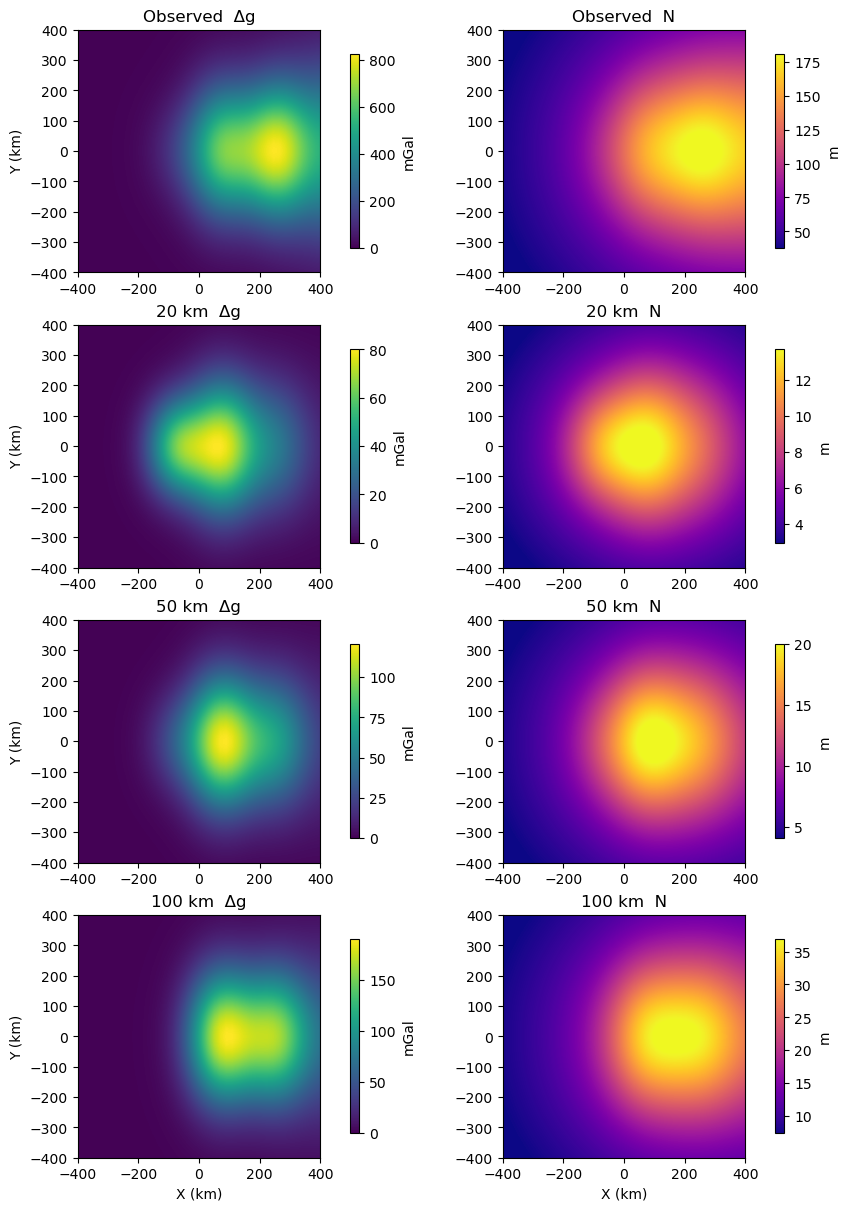

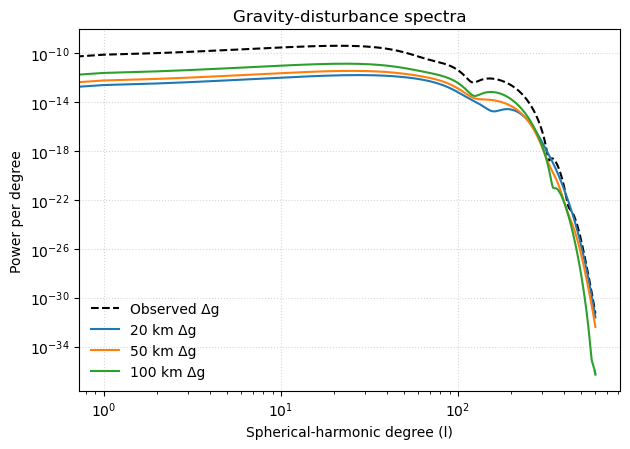

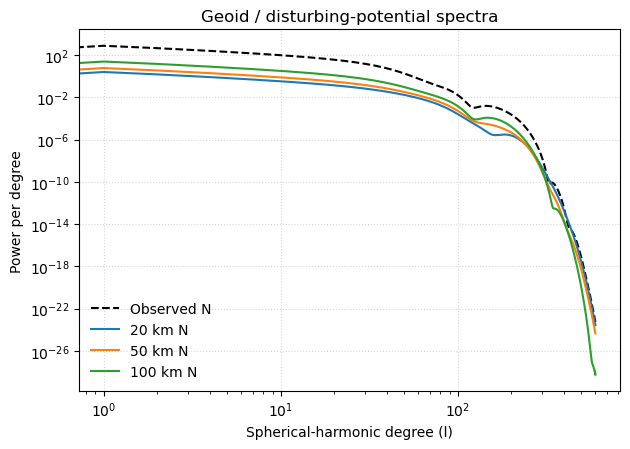

In [102]:
# =====================================================================
#  3-D model (Sheild)
# =====================================================================

import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
from scipy.interpolate import RegularGridInterpolator as RGI
from pyswarm import pso
plt.close('all')

# ───── constants & global grid ─────────────────────────────────────────────
R, g0 = 6_371e3, 9.81
G     = pysh.constants.G.value
lmax  = 1024
l_cut = 600
l     = np.arange(lmax+1)

nlat = nlon = 2*lmax + 3
lat  = np.linspace( 90,-90,nlat,endpoint=False)
lon  = np.linspace(-180,180,nlon,endpoint=False)
lon_g, lat_g = np.meshgrid(lon, lat)
xg = R*np.radians(lon_g)*np.cos(np.radians(lat_g))
yg = R*np.radians(lat_g)

# ───── build four Gaussian bodies ──────────────────────────────
km = 1e3
nz, zmax = 301, 300*km
z  = np.linspace(0, zmax, nz);  dz = z[1]-z[0]

def gauss3d(x0,y0,z0,sx,sy,sz,rho0):
    X=xg[...,None]; Y=yg[...,None]; Z=z
    return rho0*np.exp(-(((X-x0)**2)/(2*sx**2)+
                         ((Y-y0)**2)/(2*sy**2)+
                         ((Z-z0)**2)/(2*sz**2)))
anoms=[(-75*km,0, 20*km, 70*km,110*km, 15*km, 50),
       ( 75*km,0, 80*km, 80*km,150*km,100*km, 70),
       (250*km,0,170*km, 80*km,150*km,100*km, 70),
       (500*km,0,250*km,150*km,200*km,100*km, 70)]
rho3d = sum(gauss3d(*p) for p in anoms)

# ───── depth shells --------------------------------------------------------
bands  = [(0,30*km), (30*km,70*km), (70*km,130*km)]
labels = ['20 km','50 km','100 km']
Sigma_shells = []
for z1,z2 in bands:
    k1,k2 = np.searchsorted(z,[z1,z2])
    Sigma_shells.append(rho3d[:,:,k1:k2].sum(axis=2)*dz)
Sigma_obs = rho3d.sum(axis=2)*dz

# ────────────────── band-pass optimisation ───────────────────────
def gauss_taper(lc, sig):
    return np.exp(-0.5 * ((l - lc) / sig) ** 2)

def band_gravity(glm, W):
    tmp = glm.copy()
    tmp.coeffs *= W[None, :, None]
    return tmp.expand('DH').data * 1e5          # mGal

λ = 1e-3                                        # Tikhonov weight

def run_single_taper(target_g, target_glm, tag):
    def misfit(p):
        lc, sig = p
        W = gauss_taper(lc, sig)
        g_fit = band_gravity(target_glm, W)
        return np.linalg.norm(target_g - g_fit) + λ * sig**2

    (best, _) = pso(
        misfit,
        lb=[30,  20], 
        ub=[400, 150],
        swarmsize=16, maxiter=60,
        phip=1.5, phig=1.5, debug=False
    )
    lc, sig = best
    print(f"[{tag} layer]  Swarm converged")

# ───── sigma → (g, N, glm) helper --------------------------------------------
def sigma_to_fields(Sigma):
    Slm = pysh.SHGrid.from_array(Sigma,'DH').expand(
            normalization='schmidt',csphase=1,lmax_calc=lmax)
    V   = Slm.copy()
    V.coeffs *= (4*np.pi*G*R/(2*l+1))[None,:,None];  V.coeffs[:,0,0]=0
    glm = V.copy();   glm.coeffs *= -((l+1)/R)[None,:,None]
    g_DH = glm.expand('DH').data*1e5
    N_DH = V.expand('DH').data / g0
    return g_DH, N_DH, glm

g_obs_DH, N_obs_DH, glm_obs      = sigma_to_fields(Sigma_obs)
g_shells , N_shells , glm_shells = zip(*(sigma_to_fields(S) for S in Sigma_shells))

# run PSO for each depth shell --------------------------------------
for depth_label, gD, glD in zip(labels, g_shells, glm_shells):
    run_single_taper(gD, glD, depth_label)

def apply_lcut(glm):
    if l_cut is None:              
        return glm
    tmp = glm.copy()
    tmp.coeffs[:, l_cut+1:, :] = 0.0
    return tmp

glm_obs   = apply_lcut(glm_obs)
glm_shells = [apply_lcut(gl) for gl in glm_shells]

# ───── DH → local window ---------------------------------------------------
def to_window(F_DH, size=400e3, nxy=801):
    x = y = np.linspace(-size, size, nxy)
    X, Y = np.meshgrid(x, y, indexing='xy')
    lat_xy = np.degrees(Y / R)
    lon_xy = np.degrees(X / R)
    pts = np.c_[lat_xy.ravel(), lon_xy.ravel()]
    return RGI((lat, lon), F_DH, bounds_error=False)(pts).reshape(nxy, nxy)

# ───── map panel -----------------------------------------------------------
titles = ['Observed'] + labels
maps_g = [g_obs_DH] + list(g_shells)
maps_N = [N_obs_DH] + list(N_shells)

fig,ax = plt.subplots(4,2,figsize=(8.5,12),constrained_layout=True)
for i,(gF,nF,title) in enumerate(zip(maps_g,maps_N,titles)):
    g_win = to_window(gF)
    im=ax[i,0].imshow(-g_win, cmap='viridis',
                      vmin=-np.min(np.abs(g_win)),
                      vmax= np.max(np.abs(g_win)),
                      extent=[-400,400,-400,400], origin='lower')
    ax[i,0].set(title=f'{title}  Δg', ylabel='Y (km)')
    plt.colorbar(im,ax=ax[i,0],shrink=.8,label='mGal')

    n_win = to_window(nF)
    vmin,vmax=np.nanpercentile(n_win,[2,98])
    im=ax[i,1].imshow(n_win, cmap='plasma', vmin=vmin, vmax=vmax,
                      extent=[-400,400,-400,400], origin='lower')
    ax[i,1].set(title=f'{title}  N')
    plt.colorbar(im,ax=ax[i,1],shrink=.8,label='m')
for a in ax[-1,:]: a.set_xlabel('X (km)')
plt.show()

# ───── degree spectra ------------------------------------------------
def spec_g(glm):
    return glm.spectrum(unit='per_l')

def spec_N(glm):
    V = glm.copy()
    V.coeffs /= ((l + 1) / R)[None, :, None]
    return V.spectrum(unit='per_l')

ℓ_plot = l if l_cut is None else np.arange(l_cut + 1)
col     = ['C0', 'C1', 'C2']            # shell colours

# ---------- 1) gravity-disturbance spectra  -------------------------------
plt.figure(figsize=(6.4, 4.6))
plt.loglog(ℓ_plot, spec_g(glm_obs)[:ℓ_plot.size],
           'k--', label='Observed Δg')
for c, gl, lab in zip(col, glm_shells, labels):
    plt.loglog(ℓ_plot, spec_g(gl)[:ℓ_plot.size],
               c, label=f'{lab} Δg')
plt.grid(ls=':', alpha=.5)
plt.legend(frameon=False)
plt.xlabel('Spherical-harmonic degree (l)')
plt.ylabel('Power per degree')
plt.title(f'Gravity-disturbance spectra')
plt.tight_layout()
plt.show()

# ---------- 2) geoid / disturbing-potential spectra  ----------------------
plt.figure(figsize=(6.4, 4.6))
plt.loglog(ℓ_plot, spec_N(glm_obs)[:ℓ_plot.size],
           'k--', label='Observed N')
for c, gl, lab in zip(col, glm_shells, labels):
    plt.loglog(ℓ_plot, spec_N(gl)[:ℓ_plot.size],
               c, label=f'{lab} N')
plt.grid(ls=':', alpha=.5)
plt.legend(frameon=False)
plt.xlabel('Spherical-harmonic degree (l)')
plt.ylabel('Power per degree')
plt.title(f'Geoid / disturbing-potential spectra')
plt.tight_layout()
plt.show()

Stopping search: Swarm best objective change less than 1e-08
[20 km]  Swarm converged
Stopping search: Swarm best objective change less than 1e-08
[50 km]  Swarm converged
Stopping search: Swarm best objective change less than 1e-08
[100 km]  Swarm converged


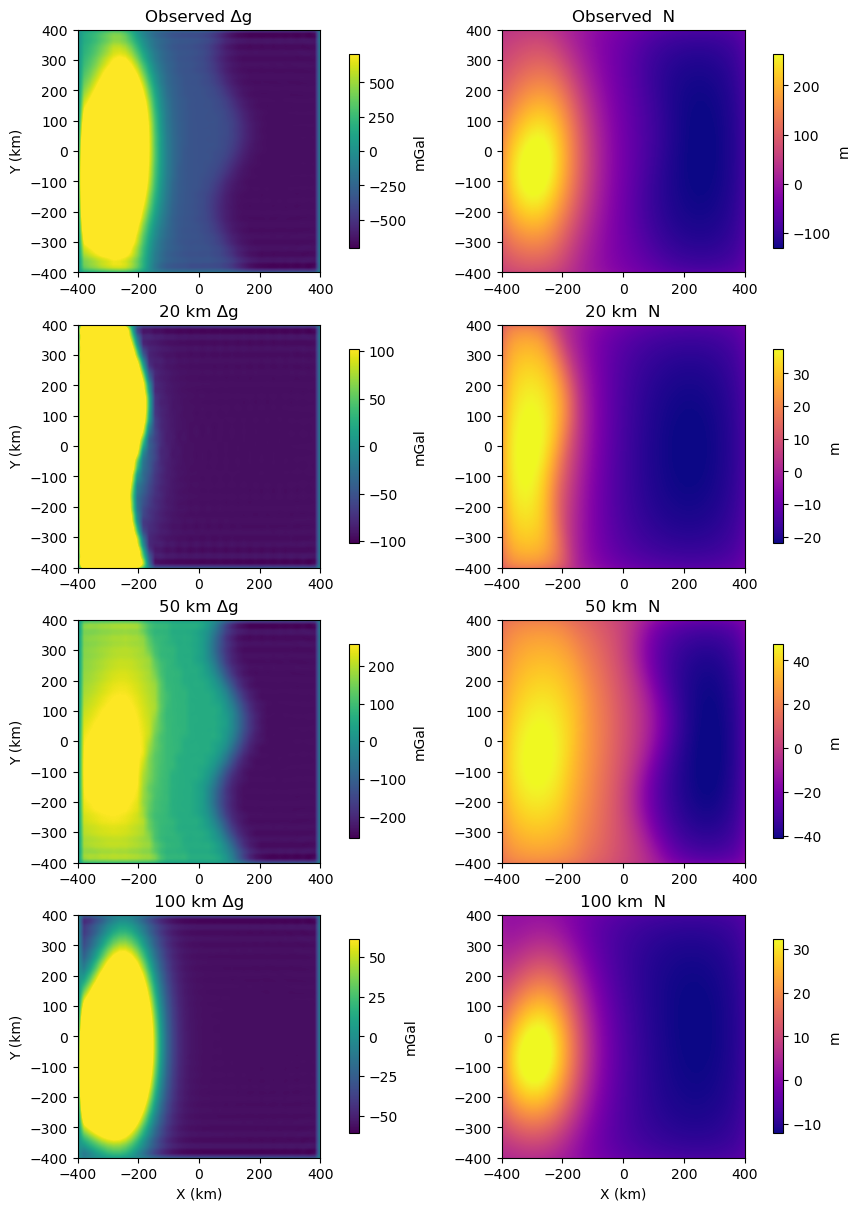

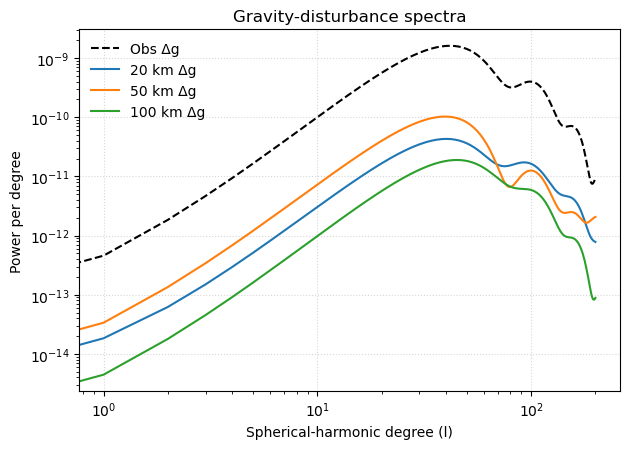

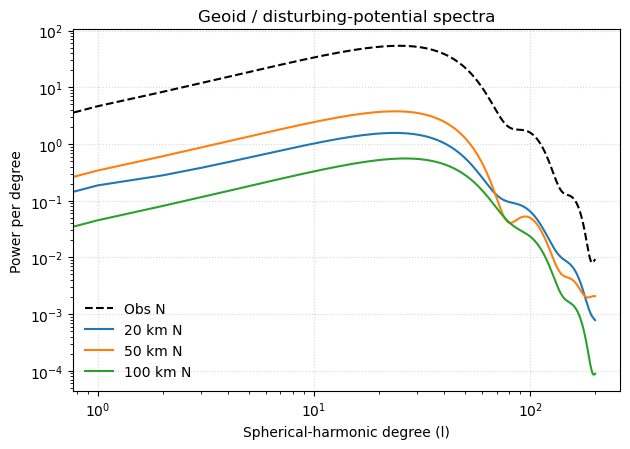

In [123]:
#  3-D density model (Subduction)

import numpy as np, matplotlib.pyplot as plt, pyshtools as pysh
from scipy.interpolate import RegularGridInterpolator as RGI
from pyswarm import pso
plt.close('all')

# ---------- constants & global DH grid ---------------------------------
R, g0 = 6_371e3, 9.81
G     = pysh.constants.G.value
lmax  = 1024
l_cut = 200
l_glob = np.arange(lmax+1)

nlat = nlon = 2*lmax + 3
lat  = np.linspace( 90,-90, nlat, endpoint=False)
lon  = np.linspace(-180,180, nlon, endpoint=False)
lon_g, lat_g = np.meshgrid(lon, lat)

DT = np.float32

km          = 1e3
nxy, nz     = 401, 301
region      = 400e3                    # ±400 km
depth_max   = 300*km

x = np.linspace(-region, region, nxy, dtype=DT)
y = np.linspace(-region, region, nxy, dtype=DT)
z = np.linspace(0, depth_max, nz, dtype=DT)
dz = DT(z[1]-z[0])
X, Y = np.meshgrid(x, y, indexing='xy')

# ---------- helpers ----------------------------------------------------
def sin_wiggle(Y, amp, L, phase=0.):
    return DT(amp)*np.sin(2*np.pi*Y/DT(L)+phase)

def gaussian_xy(x0,y0,sx,sy):
    return np.exp(-((X-DT(x0))**2/(2*DT(sx)**2) +
                    (Y-DT(y0))**2/(2*DT(sy)**2)), dtype=DT)

# ---------- geometry & parameters -------------------------------------
z_moho_oc,z_moho_cc,z_moho_deep = DT(10e3),DT(35e3),DT(60e3)
x_tr1_center,w1,A1,L1 = DT(-200e3),DT(40e3),DT(30e3),DT(600e3)
x_tr2_center,w2,A2,L2 = DT( 100e3),DT(50e3),DT(40e3),DT(500e3)

x_tr1 = x_tr1_center + sin_wiggle(Y,A1,L1)
x_tr2 = x_tr2_center + sin_wiggle(Y,A2,L2,phase=np.pi/4)
z_moho = (
    z_moho_oc +
    (z_moho_cc - z_moho_oc)*0.5*(1+np.tanh((X-x_tr1)/w1)) +
    (z_moho_deep-z_moho_cc)*0.5*(1+np.tanh((X-x_tr2)/w2))
).astype(DT)
z_moho = np.minimum(z_moho, z_moho_deep)

x_trench_center,Atr,Ltr = DT(-250e3),DT(50e3),DT(700e3)
x_trench = x_trench_center + sin_wiggle(Y,Atr,Ltr,phase=np.pi/3)
dip = np.deg2rad(DT(20.) + DT(5.)*np.sin(2*np.pi*Y/DT(800e3))).astype(DT)

s              = X - x_trench
z_slab_top     = np.where(s>0, s*np.tan(dip), np.nan).astype(DT)
slab_thickness = DT(20e3)
z_slab_bottom  = z_slab_top + slab_thickness
z_cut          = DT(200e3)

rho_crust,rho_mantle = DT(2800.),DT(3300.)
alpha_crust,alpha_mantle = DT(0.005),DT(0.0008)
rho_slab_contrast = DT(30.)

G1_xy = gaussian_xy(-250e3,  0e3, 70e3,220e3)
G2_xy = gaussian_xy(-350e3,-100e3, 90e3,150e3)
rho0_1,rho0_2 = DT(200.),DT(150.)
sz1,sz2 = DT(170e3),DT(150e3)
z01,z02 = DT(300e3),DT(250e3)

bands  = [(0,30e3),(30e3,70e3),(70e3,130e3)]
labels = ['20 km','50 km','100 km']

Σ_obs_cart    = np.zeros((nxy,nxy),dtype=DT)
Σ_shells_cart = [np.zeros_like(Σ_obs_cart) for _ in bands]
shell_idx = [np.searchsorted(z,[DT(z1),DT(z2)]) for z1,z2 in bands]

for k,zk in enumerate(z):
    bg = np.where(zk<z_moho,
                  rho_crust+alpha_crust*zk,
                  rho_mantle+alpha_mantle*zk).astype(DT)
    mask = (s>0)&(zk>=z_slab_top)&(zk<=z_slab_bottom)&(zk<=z_cut)
    if mask.any(): bg[mask] += rho_slab_contrast
    np.minimum(bg, rho_mantle+DT(30.), out=bg)

    zfac1 = np.exp(-((zk-z01)**2)/(2*sz1**2),dtype=DT)
    zfac2 = np.exp(-((zk-z02)**2)/(2*sz2**2),dtype=DT)
    rho2d = bg + rho0_1*G1_xy*zfac1 + rho0_2*G2_xy*zfac2

    rho2d -= rho2d.mean()          #  <--  OPTION B  (remove lateral mean)

    Σ_obs_cart += rho2d*dz
    for arr,(k1,k2) in zip(Σ_shells_cart,shell_idx):
        if k1<=k<k2: arr += rho2d*dz

# ---------- DH grid ----------------------------
lat_cart = np.degrees(y / R)            # −3.59° … +3.59°
lon_cart = np.degrees(x / R)            # −3.59° … +3.59°

def upsample(S):
    interp = RGI((lat_cart[::-1], lon_cart), S[::-1],
                 bounds_error=False, fill_value=0.)
    return interp((lat_g, lon_g)).astype(DT)

Σ_obs    = upsample(Σ_obs_cart)
Σ_shells = [upsample(S) for S in Σ_shells_cart]

# =====================================================================
# SH fields
# =====================================================================
def Σ_to_fields(Σ):
    Slm = pysh.SHGrid.from_array(Σ,'DH').expand(
            normalization='schmidt', csphase=1, lmax_calc=lmax)
    V = Slm.copy()
    V.coeffs *= (4*np.pi*G*R/(2*l_glob+1))[None,:,None]; V.coeffs[:,0,0]=0
    glm = V.copy(); glm.coeffs *= -((l_glob+1)/R)[None,:,None]
    return (glm.expand('DH').data*1e5,
            V.expand('DH').data/g0,
            glm)

g_obs_DH,N_obs_DH,glm_obs      = Σ_to_fields(Σ_obs)
g_shells,N_shells,glm_shells   = zip(*(Σ_to_fields(S) for S in Σ_shells))

λ=1e-3
def fit_taper(g_t,glm_t,tag):
    def taper(lc,σ): return np.exp(-0.5*((l_glob-lc)/σ)**2)
    def g_band(W): tmp=glm_t.copy(); tmp.coeffs*=W[None,:,None]; return tmp.expand('DH').data*1e5
    def J(p): lc,σ=p; return np.linalg.norm(g_t-g_band(taper(lc,σ)))+λ*σ**2
    pso(J,lb=[30,20],ub=[400,150],swarmsize=16,maxiter=60,phip=1.5,phig=1.5,debug=False)
    print(f"[{tag}]  Swarm converged")
for lab,gD,glD in zip(labels,g_shells,glm_shells):
    fit_taper(gD,glD,lab)

# =====================================================================
# plots
# =====================================================================
def lcut(gl): 
    if l_cut is None: return gl
    out=gl.copy(); out.coeffs[:,l_cut+1:,:]=0; return out
glm_obs=lcut(glm_obs); glm_shells=[lcut(gl) for gl in glm_shells]

def window(F,size=400e3,nxy=801):
    xx=yy=np.linspace(-size,size,nxy)
    Xw,Yw=np.meshgrid(xx,yy,indexing='xy')
    lat_xy=np.degrees(Yw/R); lon_xy=np.degrees(Xw/R)
    interp=RGI((lat,lon),F,bounds_error=False)
    return interp(np.c_[lat_xy.ravel(),lon_xy.ravel()]).reshape(nxy,nxy)

titles=['Observed']+labels
maps_g=[g_obs_DH]+list(g_shells)
maps_N=[N_obs_DH]+list(N_shells)

fig,ax=plt.subplots(4,2,figsize=(8.5,12),constrained_layout=True)
for i,(gF,nF,t) in enumerate(zip(maps_g,maps_N,titles)):
    g_win=window(gF)
    im=ax[i,0].imshow(-g_win,cmap='viridis',
                      vmin=-g_win.max(),vmax=g_win.max(),
                      extent=[-400,400,-400,400],origin='lower')
    ax[i,0].set(title=f'{t} Δg',ylabel='Y (km)')
    plt.colorbar(im,ax=ax[i,0],shrink=.8,label='mGal')

    n_win=window(nF); vmin,vmax=np.nanpercentile(n_win,[2,98])
    im=ax[i,1].imshow(n_win,cmap='plasma',vmin=vmin,vmax=vmax,
                      extent=[-400,400,-400,400],origin='lower')
    ax[i,1].set(title=f'{t}  N')
    plt.colorbar(im,ax=ax[i,1],shrink=.8,label='m')
for a in ax[-1,:]: a.set_xlabel('X (km)')
plt.show()

# ---------- degree spectra -------------------------------------------
def spec_g(gl): return gl.spectrum(unit='per_l')
def spec_N(gl):
    V=gl.copy(); V.coeffs/=((l_glob+1)/R)[None,:,None]; return V.spectrum(unit='per_l')

ℓplt = l_glob if l_cut is None else np.arange(l_cut+1); col=['C0','C1','C2']

plt.figure(figsize=(6.4,4.6))
plt.loglog(ℓplt,spec_g(glm_obs)[:ℓplt.size],'k--',label='Obs Δg')
for c,gl,lab in zip(col,glm_shells,labels):
    plt.loglog(ℓplt,spec_g(gl)[:ℓplt.size],c,label=f'{lab} Δg')
plt.grid(ls=':',alpha=.5); plt.legend(frameon=False)
plt.xlabel('Spherical-harmonic degree (l)'); plt.ylabel('Power per degree')
plt.title('Gravity-disturbance spectra'); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.4,4.6))
plt.loglog(ℓplt,spec_N(glm_obs)[:ℓplt.size],'k--',label='Obs N')
for c,gl,lab in zip(col,glm_shells,labels):
    plt.loglog(ℓplt,spec_N(gl)[:ℓplt.size],c,label=f'{lab} N')
plt.grid(ls=':',alpha=.5); plt.legend(frameon=False)
plt.xlabel('Spherical-harmonic degree (l)'); plt.ylabel('Power per degree')
plt.title('Geoid / disturbing-potential spectra'); plt.tight_layout(); plt.show()


Stopping search: Swarm best objective change less than 1e-08
[20 km]  Swarm converged
Stopping search: Swarm best objective change less than 1e-08
[50 km]  Swarm converged
Stopping search: Swarm best objective change less than 1e-08
[100 km]  Swarm converged


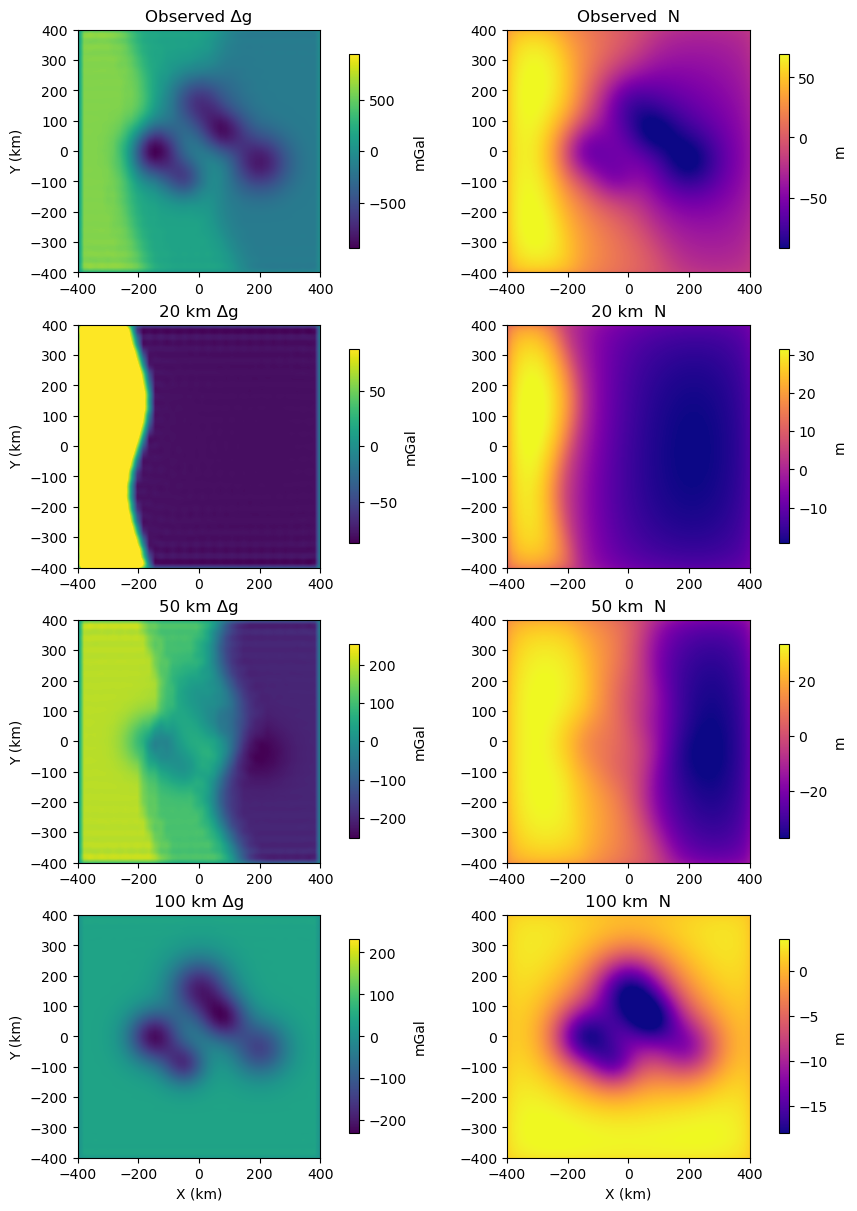

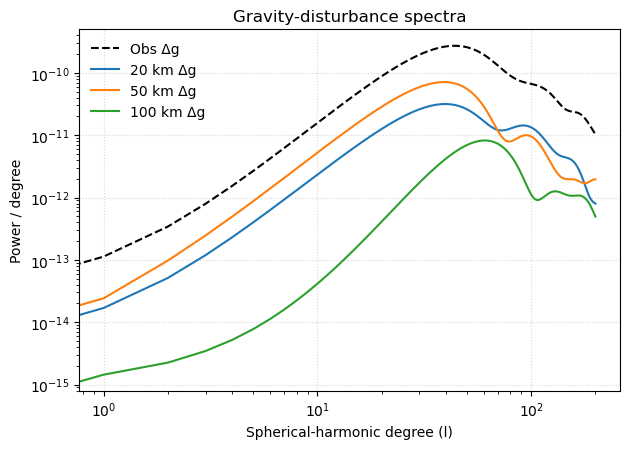

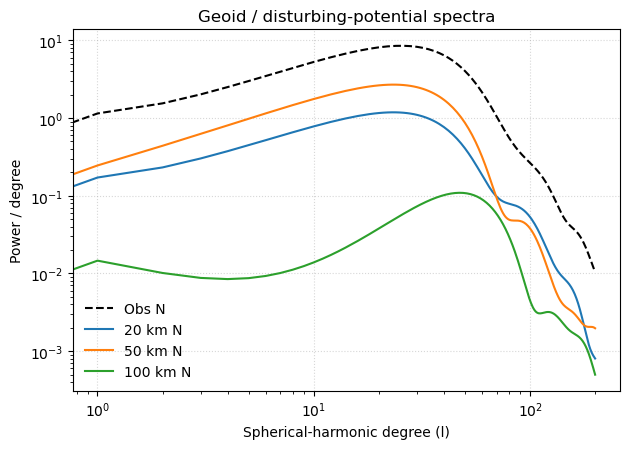

In [126]:
#  3-D density model (plumes)

import numpy as np, matplotlib.pyplot as plt, pyshtools as pysh
from  scipy.interpolate import RegularGridInterpolator as RGI
from  pyswarm import pso
plt.close('all')

# ---------- constants & global DH grid ---------------------------------
R, g0 = 6_371e3, 9.81
G     = pysh.constants.G.value
lmax  = 1024
l_cut = 200                      
l_glob = np.arange(lmax+1)

nlat = nlon = 2*lmax + 3      
lat  = np.linspace( 90,-90, nlat, endpoint=False)
lon  = np.linspace(-180,180, nlon, endpoint=False)
lon_g, lat_g = np.meshgrid(lon, lat)

DT = np.float32

# =====================================================================
# density model
# =====================================================================
km = 1e3
# ---- Cartesian grid dimensions (model domain) ------------------------
region   = 400e3                  # ±400 km
depth_max= 300e3
nxy, nz  = 200, 200          
x = np.linspace(-region, region, nxy, dtype=DT)
y = np.linspace(-region, region, nxy, dtype=DT)
z = np.linspace(0,        depth_max, nz, dtype=DT)
dz = DT(z[1] - z[0])
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# ---- Moho geometry ----------------------------
def sin_wiggle(Y, amp, L, phase=0.): return amp*np.sin(2*np.pi*Y/L + phase)

z_moho_oc, z_moho_cc, z_moho_deep = 10e3, 35e3, 60e3
x_tr1_center,w1,A1,L1 = -200e3, 40e3, 30e3, 600e3
x_tr2_center,w2,A2,L2 =  100e3, 50e3, 40e3, 500e3
x_tr1 = x_tr1_center + sin_wiggle(Y, A1, L1)
x_tr2 = x_tr2_center + sin_wiggle(Y, A2, L2, phase=np.pi/4)

z_moho_surface = ( z_moho_oc
    + (z_moho_cc  - z_moho_oc )*0.5*(1+np.tanh((X-x_tr1)/w1))
    + (z_moho_deep- z_moho_cc)*0.5*(1+np.tanh((X-x_tr2)/w2)) )
z_moho_surface = np.minimum(z_moho_surface, z_moho_deep)

# ---- background lithosphere density ---------------------------------
rho_crust,  rho_mantle  = 2800., 3300.      # kg m⁻³
alpha_crust,alpha_mantle= 0.005, 0.0008     # kg m⁻³ m⁻¹
rho_background = np.where(
    Z < z_moho_surface,
    rho_crust  + alpha_crust  * Z,
    rho_mantle + alpha_mantle * Z
)

# ---- 5 mantle plumes -------------------------------------------------
def plume_3d(x0,y0,r0,z_top,z_bot,drho0,sigma_r=None,sigma_z=None):
    sigma_r = r0 if sigma_r is None else sigma_r
    sigma_z = (z_bot-z_top) if sigma_z is None else sigma_z
    r2 = (X-x0)**2 + (Y-y0)**2
    radial  = np.exp(-r2/(2*sigma_r**2))
    vertical= np.exp(-(Z-(z_top+z_bot)/2)**2/(2*sigma_z**2))
    mask    = (Z>=z_top)&(Z<=z_bot)
    return drho0 * radial * vertical * mask

plume_specs = np.array([
    [-150,   0,  60,  30, 300, -100],
    [ -50, -90,  50,  40, 250,  -75],
    [  80,  60,  55,  35, 270,  -85],
    [ 200, -40,  65,  50, 280,  -70],
    [   0, 160,  70,  45, 260,  -90],
]) * np.array([1e3,1e3,1e3,1e3,1e3,1])

rho_plume = np.zeros_like(rho_background)
for xc,yc,rc,zt,zb,drho in plume_specs:
    rho_plume += plume_3d(xc,yc,rc,zt,zb,drho)

# ---- total density ---------------------------------------------------
rho_total = rho_background + rho_plume         

# ---- depth shells --------------------
bands  = [(0,30e3),(30e3,70e3),(70e3,130e3)]
labels = ['20 km','50 km','100 km']

Σ_obs_cart    = np.zeros((nxy,nxy), dtype=DT)
Σ_shells_cart = [np.zeros_like(Σ_obs_cart) for _ in bands]
shell_idx     = [np.searchsorted(z,[z1,z2]) for z1,z2 in bands]

for k,zk in enumerate(z):
    rho2d = rho_total[:,:,k].astype(DT)
    rho2d -= rho2d.mean()                      
    Σ_obs_cart += rho2d*dz
    for arr,(k1,k2) in zip(Σ_shells_cart, shell_idx):
        if k1<=k<k2: arr += rho2d*dz

# ---------- DH grid ---------------------------
lat_cart = np.degrees(y / R)
lon_cart = np.degrees(x / R)
def upsample(S_xy):
    S_yx = S_xy.T                   
    interp = RGI(
        (lat_cart[::-1], lon_cart),   
        S_yx[::-1],                 
        bounds_error=False, fill_value=0.0)
    return interp((lat_g, lon_g)).astype(DT)  

Σ_obs    = upsample(Σ_obs_cart)
Σ_shells = [upsample(S) for S in Σ_shells_cart]

# =====================================================================
# solver, PSO, plotting
# =====================================================================

def Σ_to_fields(Σ):
    Slm = pysh.SHGrid.from_array(Σ,'DH').expand(
            normalization='schmidt', csphase=1, lmax_calc=lmax)
    V = Slm.copy()
    V.coeffs *= (4*np.pi*G*R/(2*l_glob+1))[None,:,None]; V.coeffs[:,0,0]=0
    glm = V.copy(); glm.coeffs *= -((l_glob+1)/R)[None,:,None]
    return (glm.expand('DH').data*1e5,
            V.expand('DH').data/g0,
            glm)

g_obs_DH,N_obs_DH,glm_obs      = Σ_to_fields(Σ_obs)
g_shells,N_shells,glm_shells   = zip(*(Σ_to_fields(S) for S in Σ_shells))

λ=1e-3
def fit_taper(g_t,glm_t,tag):
    def taper(lc,σ): return np.exp(-0.5*((l_glob-lc)/σ)**2)
    def g_band(W): tmp=glm_t.copy(); tmp.coeffs*=W[None,:,None]; return tmp.expand('DH').data*1e5
    def J(p): lc,σ=p; return np.linalg.norm(g_t-g_band(taper(lc,σ)))+λ*σ**2
    pso(J,lb=[30,20],ub=[400,150],swarmsize=16,maxiter=60,phip=1.5,phig=1.5,debug=False)
    print(f"[{tag}]  Swarm converged")
for lab,gD,glD in zip(labels,g_shells,glm_shells):
    fit_taper(gD,glD,lab)

# ---------------- plots & spectra ------------------------
def lcut(gl):
    if l_cut is None: return gl
    out=gl.copy(); out.coeffs[:,l_cut+1:,:]=0; return out
glm_obs=lcut(glm_obs); glm_shells=[lcut(gl) for gl in glm_shells]

def window(F,size=400e3,nxy=801):
    xx=yy=np.linspace(-size,size,nxy)
    Xw,Yw=np.meshgrid(xx,yy,indexing='xy')
    lat_xy=np.degrees(Yw/R); lon_xy=np.degrees(Xw/R)
    interp=RGI((lat,lon),F,bounds_error=False)
    return interp(np.c_[lat_xy.ravel(),lon_xy.ravel()]).reshape(nxy,nxy)

titles=['Observed']+labels
maps_g=[g_obs_DH]+list(g_shells)
maps_N=[N_obs_DH]+list(N_shells)

fig,ax=plt.subplots(4,2,figsize=(8.5,12),constrained_layout=True)
for i,(gF,nF,t) in enumerate(zip(maps_g,maps_N,titles)):
    g_win=window(gF)
    im=ax[i,0].imshow(-g_win,cmap='viridis',
                      vmin=-g_win.max(),vmax=g_win.max(),
                      extent=[-400,400,-400,400],origin='lower')
    ax[i,0].set(title=f'{t} Δg',ylabel='Y (km)')
    plt.colorbar(im,ax=ax[i,0],shrink=.8,label='mGal')

    n_win=window(nF); vmin,vmax=np.nanpercentile(n_win,[2,98])
    im=ax[i,1].imshow(n_win,cmap='plasma',vmin=vmin,vmax=vmax,
                      extent=[-400,400,-400,400],origin='lower')
    ax[i,1].set(title=f'{t}  N')
    plt.colorbar(im,ax=ax[i,1],shrink=.8,label='m')
for a in ax[-1,:]: a.set_xlabel('X (km)')
plt.show()

def spec_g(gl): return gl.spectrum(unit='per_l')
def spec_N(gl):
    V=gl.copy(); V.coeffs/=((l_glob+1)/R)[None,:,None]; return V.spectrum(unit='per_l')

ℓplt = l_glob if l_cut is None else np.arange(l_cut+1); col=['C0','C1','C2']

plt.figure(figsize=(6.4,4.6))
plt.loglog(ℓplt,spec_g(glm_obs)[:ℓplt.size],'k--',label='Obs Δg')
for c,gl,lab in zip(col,glm_shells,labels):
    plt.loglog(ℓplt,spec_g(gl)[:ℓplt.size],c,label=f'{lab} Δg')
plt.grid(ls=':',alpha=.5); plt.legend(frameon=False)
plt.xlabel('Spherical-harmonic degree (l)'); plt.ylabel('Power / degree')
plt.title('Gravity-disturbance spectra'); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.4,4.6))
plt.loglog(ℓplt,spec_N(glm_obs)[:ℓplt.size],'k--',label='Obs N')
for c,gl,lab in zip(col,glm_shells,labels):
    plt.loglog(ℓplt,spec_N(gl)[:ℓplt.size],c,label=f'{lab} N')
plt.grid(ls=':',alpha=.5); plt.legend(frameon=False)
plt.xlabel('Spherical-harmonic degree (l)'); plt.ylabel('Power / degree')
plt.title('Geoid / disturbing-potential spectra'); plt.tight_layout(); plt.show()
